In [1]:
import pandas as pd 
import numpy as np  
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns

import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import tensorflow as tf
from keras.models import Model, Sequential, load_model
from keras.callbacks import EarlyStopping
from keras.losses import MeanSquaredError, Huber,MeanAbsoluteError
from keras.layers import Dense, LSTM, Reshape,Dropout,Bidirectional
from keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from vmdpy import VMD

from typing import List as List, Tuple as Tuple, Dict as Dict,Optional as Optional

2024-02-11 18:30:33.343239: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-11 18:30:33.343333: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-11 18:30:33.399580: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
df_load = pd.read_csv("/mnt/e/github/load-forecast/01.database/processed/load/2022_2023_load_processed.csv", sep = ",", encoding = 'latin-1', index_col=0)
df_temp = pd.read_csv("/mnt/e/github/load-forecast/01.database/processed/temperature/2022_2023_temperature_processed.csv", sep = ',',encoding = 'latin-1', index_col=0)

df_temp['datetime'] = pd.to_datetime(df_temp['datetime'])
df_load['datetime'] = pd.to_datetime(df_load['datetime']).dt.tz_localize('UTC')

df = pd.merge(df_temp,df_load, on='datetime', how='inner')

del df_load
del df_temp

df = df.iloc[4344:]

df.head()

,datetime,temperature,total_load
4344,2022-07-01 00:00:00+00:00,18.143443,61874.013017
4345,2022-07-01 01:00:00+00:00,17.446575,59042.531005
4346,2022-07-01 02:00:00+00:00,16.976438,57149.292992
4347,2022-07-01 03:00:00+00:00,16.481543,56519.531943
4348,2022-07-01 04:00:00+00:00,16.140110,56818.247011


In [3]:
def ciclical_time_encoding(df:pd.DataFrame)->pd.DataFrame:

    """
    Encodes datetime values in a DataFrame using cyclic encoding.

    Args:
        - df: DataFrame containing a 'datetime' column to be cyclically encoded.

    Returns:
        - DataFrame with additional columns representing the cyclically encoded datetime values.
    """

    #Ciclical encoding datetime object:
    day = 1
    weekly = day*7
    year = day*365

    #Convert into an number
    timestamp_s = df['datetime'].map(datetime.timestamp)

    df = df.assign(year_sin = (np.sin(timestamp_s * (2*np.pi/year))).values)
    df = df.assign(year_cos = (np.cos(timestamp_s * (2*np.pi/year))).values)

    df = df.assign(daily_sin = (np.sin(timestamp_s * (2*np.pi/day))).values)
    df = df.assign(daily_cos = (np.cos(timestamp_s * (2*np.pi/day))).values)

    df = df.assign(weekly_sin = (np.sin(timestamp_s * (2*np.pi/weekly))).values)
    df = df.assign(weekly_cos = (np.cos(timestamp_s * (2*np.pi/weekly))).values)
    
    df.reset_index(inplace = True)
    return(df)

In [4]:
def retrieve_and_remove_datetime(df:pd.DataFrame)-> List[datetime]:

    '''
    - Args:
        - df: Dataframe to remove datetime column
    - Returns:
        - datetime_rage: Removed column as a List
    '''
   
    datetime_range = df['datetime'].to_list()
    df.drop(columns = ['datetime'], inplace = True)
    
    return datetime_range

In [5]:
def decompose_series_vmd(df:pd.DataFrame,timeseries:str, k_nmodes:int)-> pd.DataFrame:
    '''

    Decomposes a time series using Variational Mode Decomposition (VMD).
    
    - Args:
        - df: Dataframe with the timeseries that will be decomposed
        - timeseres: Dataframe column that will go trought the vmd process
        - k_nmodes: n decomposed series
    - Returns:
        - df: dataframe with new decomposed columns
    '''

    print(f"Decomposing {timeseries} in {k_nmodes} nmodes")
    
    timeseries = df[timeseries].to_list()

    alpha = 2000     # moderate bandwidth constraint  
    tau = 0           # noise-tolerance (no strict fidelity enforcement)  
    k_nmodes = k_nmodes           # n modes  
    DC = 0             # no DC part imposed  
    init = 0           # initialize omegas uniformly  
    tol = 1e-6
    u, u_hat, omega = VMD(timeseries,alpha,tau,k_nmodes,DC,init,tol)

    label_columns = []

    for i in range(len(u)):
        col_name = 'series_dec_' + str(i+1)
        df[col_name] = u[i]  
        label_columns.append('series_dec_'+str(i+1))

    return(df)

In [6]:
def split_and_scal_df(df:pd.DataFrame)-> Tuple[Dict[str,pd.DataFrame],Tuple[pd.Series,pd.Series]]:

    """
    Splits the input DataFrame into training, validation, and test sets, scales the datasets using Min-Max scaling,
    and returns the scaled DataFrames along with the min-max values used for scaling.

    Parameters:
    - df: Input DataFrame to be split and scaled.

    Returns:
    - Tuple containing:
        - A dictionary with scaled DataFrames for training, validation, and test sets.
        - A tuple containing min and max values for each feature used during scaling.
    """

    n = len(df)
    # Split 70:20:10 (train:validation:test)
    train_df = df[0:int(n*0.7)]
    val_df = df[int(n*0.7):int(n*0.9)]
    test_df = df[int(n*0.9):]

    #retrieve the max and min values of each feature. This will be used to bring those values back to the original
    #dimesion after scalling it to train the model
    min_values = train_df.min()
    max_values = train_df.max()

    #Scaling the dataframes to train
    scaler = MinMaxScaler()
    scaler.fit(train_df)

    scal_df = df.copy()
    scal_df[scal_df.columns] = scaler.transform(df[df.columns])

    scal_train_df = train_df.copy()
    scal_train_df[scal_train_df.columns] = scaler.transform(train_df[train_df.columns])

    scal_val_df = val_df.copy()
    scal_val_df[scal_val_df.columns] = scaler.transform(val_df[val_df.columns])

    scal_test_df = test_df.copy()
    scal_test_df[scal_test_df.columns] = scaler.transform(test_df[test_df.columns])

    dict_scal_df = {"train_df":scal_train_df,
                    "val_df":scal_val_df,
                    "test_df":scal_test_df}

    min_max_values = (min_values,max_values)

    return dict_scal_df,min_max_values


In [7]:
k_nmodes = 20

df = ciclical_time_encoding(df = df)
datetime_range = retrieve_and_remove_datetime(df = df)
df = decompose_series_vmd(df = df, timeseries = 'total_load', k_nmodes = 10)

df.drop(columns = ['total_load'], inplace = True)
df.drop(columns = ['index'], inplace = True)

dict_df, min_max_values = split_and_scal_df(df = df)

Decomposing total_load in 10 nmodes


In [8]:
def scale_back(scaled_values,min_values:pd.Series,max_values:pd.Series,label_columns:List[str],variable = 'timeseries'):

        if variable == 'timeseries':       
                min_values = min_values.tail(len(label_columns)).values
                max_values = max_values.tail(len(label_columns)).values
                
        elif variable == 'val_loss':
                min_values = min_values.head(1).values
                max_values = max_values.head(1).values

        scaled_back = scaled_values * (max_values - min_values) + min_values

        return scaled_back

In [9]:
class DataWindow():
    """
        DataWindow class for creating time-series windows and handling time-series data for machine learning.

        Parameters:
        - input_width: int, width of the input sequence.
        - label_width: int, width of the label sequence.
        - shift: int, number of time steps to shift the label sequence.
        - train_df: pd.DataFrame, training dataset.
        - val_df: pd.DataFrame, validation dataset.
        - test_df: pd.DataFrame, test dataset.
        - label_columns: List[str], list of column names to be used as labels.
        - min_values: pd.Series, series containing minimum values for normalization.
        - max_values: pd.Series, series containing maximum values for normalization.
        - batch_size: int, size of the batches in the dataset.
        - plot_col: List[str], list of column names to be plotted.
        - steps_per_day: int, number of time steps per day.

        Methods:
        - __init__: Initializes the DataWindow object with the specified parameters.

        - split_to_inputs_labels(features): Splits the input features into inputs and labels.

        - plot(model=None, plot_col=None, max_subplots=3): Plots the inputs, labels, and predictions (if a model is provided).

        - make_dataset(data): Creates a TensorFlow dataset from the given data.

        Properties:
        - train: Returns the training dataset as a TensorFlow dataset.

        - val: Returns the validation dataset as a TensorFlow dataset.

        - test: Returns the test dataset as a TensorFlow dataset.

        - sample_batch: Returns a sample batch from the test dataset.

    """


    def __init__(self, input_width:int, 
                 label_width:int, 
                 shift:int, 
                 train_df:pd.DataFrame, 
                 val_df=pd.DataFrame, 
                 test_df=pd.DataFrame, 
                 label_columns=List[str], 
                 min_values=pd.Series,
                 max_values=pd.Series,
                 batch_size=int,
                 plot_col=List[str],
                 steps_per_day=int):
        

        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        
        self.min_values = min_values
        self.max_values = max_values

        self.steps_per_day = steps_per_day

        self.label_columns = label_columns

        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
        self.column_indices = {name: i for i, name in enumerate(train_df.columns)}
        
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift
        
        self.total_window_size = input_width + shift
        
        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]
        
        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]
    
    def split_to_inputs_labels(self, features):
        """
        Splits the input features into inputs and labels.

        Parameters:
        - features: Input features.

        Returns:
        - inputs: Sequence of input data.
        - labels: Sequence of label data.
        """

        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:,:,self.column_indices[name]] for name in self.label_columns],
                axis=-1
            )
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])
        
        return inputs, labels
    
    def plot(self, model=None, plot_col = None, max_subplots=3):
        """
        Plots the inputs, labels, and predictions (if a model is provided).

        Parameters:
        - model: Optional, TensorFlow model for making predictions.
        - plot_col: Optional, list of column names to be plotted.
        - max_subplots: Optional, maximum number of subplots in the figure.

        Returns:
        - fig: Matplotlib figure.
        """

        if plot_col is None:
            plot_col = self.label_columns
        inputs, labels = self.sample_batch

        min_values = self.min_values
        max_values = self.max_values

        fig = plt.figure(figsize=(18, 8))
        plot_col_index = [self.column_indices[col] for col in plot_col]
        max_n = min(max_subplots, len(inputs))
        
        for n in range(max_n):
            plt.subplot(max_n, 1, n+1)
            plt.ylabel('Total Load [MWh]')
            #plt.ylim(0,20)
            
            sliced_inputs = inputs[:,:,-len(plot_col):]
            original_scale_inputs = scale_back(sliced_inputs,min_values = min_values,max_values = max_values,label_columns = plot_col)
            summed_inputs = tf.math.reduce_sum(original_scale_inputs,axis=2,keepdims=False,name=None)
            
            plt.plot(self.input_indices, 
                     summed_inputs[n],
                     
                     label='Inputs', 
                     marker='.',
                     c='#2E294E',
                     zorder=-10)

            if self.label_columns:
                label_col_index = [self.label_columns_indices.get(col, None) for col in plot_col]
            else:
                label_col_index = plot_col_index

            if None in label_col_index:
                continue
            
            original_scale_labels = scale_back(labels,min_values,max_values,plot_col)
            summed_label = tf.math.reduce_sum(original_scale_labels,axis=2,keepdims=False,name=None)
            #label_avg = calc_ws_avg(summed_label[n],steps_per_day)
            
            forecasting_period = int((len(summed_label[n]))/steps_per_day)

            plt.plot(self.label_indices, 
                        summed_label[n],
                        label='Labels',
                        marker='.',
                        c='#541388'
                        )
           
            if model is not None:

                predictions = model(inputs)
                original_scale_predictions = scale_back(predictions,min_values,max_values,plot_col)
                summed_predictions = tf.math.reduce_sum(original_scale_predictions,axis=2,keepdims=False,name=None)
                #predictions_avg = calc_ws_avg(summed_predictions[n],steps_per_day)

                plt.plot(self.label_indices, 
                            summed_predictions[n], 
                            label='Predictions',
                            marker='.',
                            c='#D90368'
                            )
                
                #plt.text(x=5,y=17,s='avg_ws')

                x_0 = int(len(summed_inputs[n]))
                text_position = x_0 

                plt.rcParams.update({'font.size': 7})

                # for day in range(forecasting_period):
                    
                #     text_string = 'day_' + str(day+1) + ': r = ' + str(label_avg[day]) + '| p = '+ str(predictions_avg[day])
                    
                #     plt.text(x=text_position + 3, y=17, s=text_string)
                #     plt.axvline(x=text_position, color='black',ymin = 0, ymax = (18/20),ls=':')
                #     text_position = text_position + steps_per_day

                    
            if n == 0:
                fig.legend()

        plt.xlabel('Time [daily]')
        return(fig)
    
    def make_dataset(self, data):

        """
        Creates a TensorFlow dataset from the given data.

        Parameters:
        - data: Input data.

        Returns:
        - ds: TensorFlow dataset.
        """

        data = np.array(data, dtype=np.float32)
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=True,
            batch_size=batch_size
        )
        
        ds = ds.map(self.split_to_inputs_labels)
        return ds
    
    @property
    def train(self):
        """
        Returns the training dataset as a TensorFlow dataset.

        Returns:
        - TensorFlow dataset.
        """

        return self.make_dataset(self.train_df)
    
    @property
    def val(self):
        """
        Returns the validation dataset as a TensorFlow dataset.

        Returns:
        - TensorFlow dataset.
        """

        return self.make_dataset(self.val_df)
    
    @property
    def test(self):
        """
        Returns the test dataset as a TensorFlow dataset.

        Returns:
        - TensorFlow dataset.
        """
        return self.make_dataset(self.test_df)
    
    @property
    def sample_batch(self):

        """
        Returns a sample batch from the test dataset.

        Returns:
        - Sample batch.
        """
        result = getattr(self, '_sample_batch', None)
        if result is None:
            result = next(iter(self.test))
            self._sample_batch = result
        return result

In [10]:
def plot_loss(history):
    fig, ax = plt.subplots()

    ax.plot(range(len(history.history['loss'])), history.history['loss'], label='loss', color='#D90368')
    ax.plot(range(len(history.history['val_loss'])), history.history['val_loss'], label='val_loss', color='#2E294E')

    ax.set_xlabel('epochs')
    ax.set_ylabel('loss')
    ax.set_title('training loss')
    leg = ax.legend()

    return fig


In [11]:
def compile_and_fit(model, window, patience=3, max_epochs=30):
    early_stopping = EarlyStopping(monitor='val_loss',
                                   patience=patience,
                                   mode='auto')
    
    model.compile(loss=MeanAbsoluteError(),
                  optimizer=Adam(),
                  metrics=[MeanAbsoluteError()])
    
    history = model.fit(window.train,
                       epochs=max_epochs,
                       validation_data=window.val,
                       callbacks=[early_stopping])
    
    return history

In [12]:
df

,temperature,year_sin,year_cos,daily_sin,daily_cos,weekly_sin,weekly_cos,series_dec_1,series_dec_2,series_dec_3,series_dec_4,series_dec_5,series_dec_6,series_dec_7,series_dec_8,series_dec_9,series_dec_10
0,18.143443,0.933837,0.357698,2.222824e-07,1.0,-7.818315e-01,0.623490,63384.448332,770.921833,-938.276763,1348.144284,-5585.209364,443.685686,260.611627,268.820560,-191.354154,1082.389942
1,17.446575,0.337523,0.941317,2.412496e-07,1.0,7.818315e-01,0.623490,63366.825664,580.637149,-939.290621,1325.167462,-5405.781253,205.620445,71.845269,79.281392,-249.828156,412.179877
2,16.976438,-0.493776,0.869589,2.602168e-07,1.0,4.338838e-01,-0.900969,63354.661795,255.869977,-915.225520,1303.735126,-5022.087838,-130.608195,-179.129660,-173.551360,-279.266141,-457.439400
3,16.481543,-0.981306,0.192452,2.791840e-07,1.0,-9.749279e-01,-0.222521,63353.775981,-153.225681,-858.756857,1290.519021,-4437.248207,-412.333196,-362.680812,-360.349494,-215.242257,-997.945133
4,16.140110,-0.785650,-0.618671,2.981512e-07,1.0,-2.552656e-08,1.000000,63360.184578,-601.408581,-774.251285,1281.658757,-3676.056314,-528.145107,-393.867388,-396.105274,-44.341348,-943.647655
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13171,27.682828,-0.337523,0.941317,1.765855e-07,1.0,-1.110127e-07,1.000000,75309.169778,1648.323581,-475.981196,-6029.346475,1637.484025,841.439883,837.828335,907.773911,746.150529,2611.134567
13172,26.929555,-0.933837,0.357698,1.955527e-07,1.0,9.749279e-01,-0.222521,75304.594209,1855.497661,-457.749870,-6066.756000,1935.121837,520.537294,516.624786,537.295975,439.571430,2932.471797
13173,25.981414,-0.880012,-0.474951,2.145199e-07,1.0,-4.338836e-01,-0.900969,75275.924873,1947.691843,-474.476428,-6122.469996,2125.806989,-49.855721,-52.576475,-85.841974,-85.853036,1358.582219
13174,24.842770,-0.213521,-0.976938,2.334871e-07,1.0,-7.818315e-01,0.623490,75250.578470,1982.310056,-494.382945,-6167.001682,2242.572838,-623.939030,-624.938054,-703.580098,-608.024892,-1108.805721


In [13]:
# LSTM parameters

input_days = 3
forecast_days = 7
steps_per_day = 24
batch_size = 32

# Columns forecasted
label_columns = df.columns.to_list()[7:]
features = len(df.columns)

# widht: window size in hours
input_width = steps_per_day*input_days
label_width = steps_per_day*forecast_days

# distance between first data and first forecast
shift = steps_per_day*forecast_days

mo_val_performance = {}
mo_performance = {}

# DataWindow config with parameters 
multi_step_window = DataWindow(input_width = input_width, 
                            label_width=label_width, 
                            shift=shift, 
                            label_columns=label_columns,
                            batch_size=batch_size,
                            steps_per_day=steps_per_day,
                            train_df = dict_df['train_df'],
                            test_df = dict_df['test_df'],
                            val_df = dict_df['val_df'],
                            min_values = min_max_values[0],
                            max_values = min_max_values[1])

In [14]:
val_performance = {}
test_performance = {}

#Layers Units (LU)
first_lu = 16
seccond_lu = 32
third_lu = 64
forth_lu = 0

#Dropouts (DO)
first_do = 0.0
seccond_do = 0.0

lstm_network = Sequential([
    Bidirectional(LSTM(units = first_lu,input_shape=(input_width,features),return_sequences=True)),
    Dropout(first_do),
    Bidirectional(LSTM(units = seccond_lu,return_sequences=True)),
    Dropout(seccond_do),
    Bidirectional(LSTM(units = third_lu)),
    Dense(units=shift*len(label_columns)),
    Reshape((shift,len(label_columns)))
])

hist = compile_and_fit(lstm_network,multi_step_window)

val_performance['LSTM'] = lstm_network.evaluate(multi_step_window.val)
test_performance['LSTM'] = lstm_network.evaluate(multi_step_window.test,verbose = 0)

Epoch 1/30
281/281 [==============================] - 61s 155ms/step - loss: 0.1757 - mean_absolute_error: 0.1756 - val_loss: 0.1380 - val_mean_absolute_error: 0.1380
Epoch 2/30
281/281 [==============================] - 42s 149ms/step - loss: 0.0735 - mean_absolute_error: 0.0735 - val_loss: 0.0741 - val_mean_absolute_error: 0.0741
Epoch 3/30
281/281 [==============================] - 41s 144ms/step - loss: 0.0585 - mean_absolute_error: 0.0585 - val_loss: 0.0665 - val_mean_absolute_error: 0.0665
Epoch 4/30
281/281 [==============================] - 41s 146ms/step - loss: 0.0523 - mean_absolute_error: 0.0523 - val_loss: 0.0649 - val_mean_absolute_error: 0.0649
Epoch 5/30
281/281 [==============================] - 41s 146ms/step - loss: 0.0481 - mean_absolute_error: 0.0481 - val_loss: 0.0619 - val_mean_absolute_error: 0.0619
Epoch 6/30
281/281 [==============================] - 41s 146ms/step - loss: 0.0458 - mean_absolute_error: 0.0458 - val_loss: 0.0613 - val_mean_absolute_error: 0.061

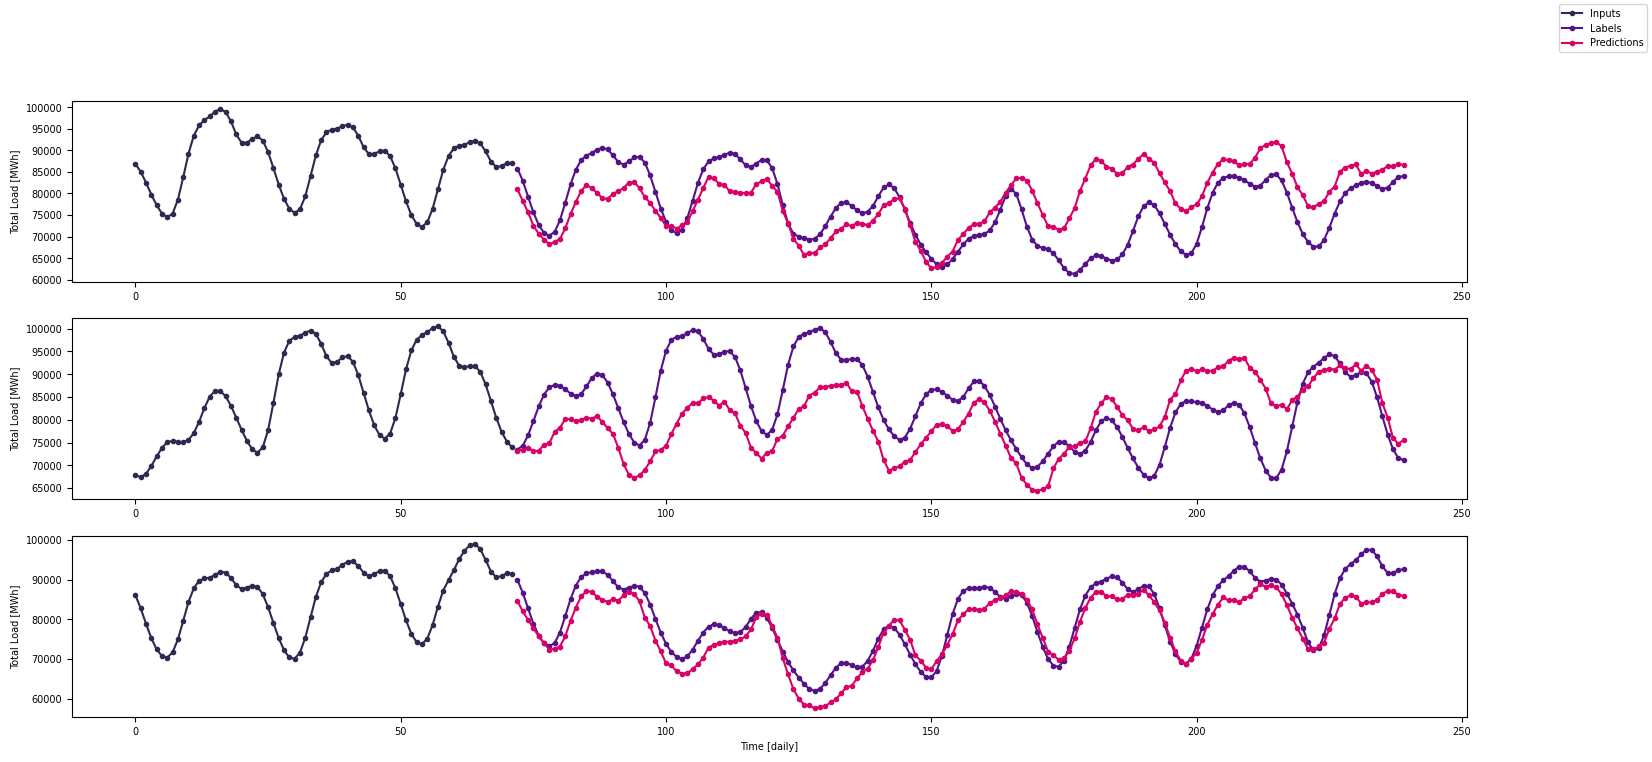

In [19]:
fig = multi_step_window.plot(model = lstm_network)
fig.show()

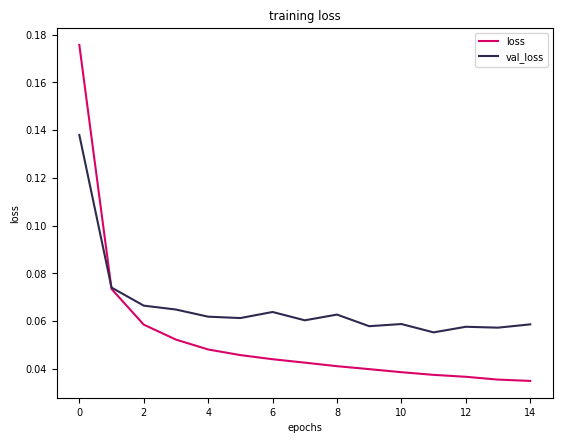

In [20]:
loss_fig = plot_loss(history = hist)
loss_fig.show()

In [22]:
lstm_network.save(f'load_forecast_with_temperature_knmodes_{k_nmodes}.hdf5')
lstm_network.save(f'load_forecast_with_temperature_knmodes_{k_nmodes}.keras')